<a href="https://colab.research.google.com/github/JackBstn/NLP/blob/main/chronos_multivariate_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chronos adaptation to Multivariate Input: Preprocessing Multivariate Time Series

This notebook is designed to explore preprocessing techniques that transform multivariate time series data into univariate formats suitable for analysis with Chronos. It focuses on two primary preprocessing methods:
1. **Simple Transformation Methods**: Aggregating multiple variables into a single representative feature (Weighted Sum, Arithmetic Mean, PCA).
2. **Machine Learning-Based Methods**: Employ machine learning models to capture the underlying relationships among variables (Linear Regression, Random Forest, Support Vector Regression).

In this notebook, we apply these techniques to Apple stock market data, where the goal is to predict the Close price. The dataset includes multiple financial indicators (Open, High, Low, Volume, Close), and our preprocessing steps will transform these multivariate inputs into a univariate format, enabling the application of Chronos for forecasting. For comparison, we also evaluate Chronos using only the historical values of the Close price as input, without any transformation from multivariate data. This allows us to determine whether incorporating additional variables enhances forecasting performance.

The evaluation includes calculating various metrics such as MSE, RMSE, MAPE, and MASE,
and visualizing the forecast results to compare the performance of the fine-tuned model against the zero-shot model.

#### Install Dependencies

In [1]:
!pip install torch transformers chronos yfinance pandas matplotlib
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.4 MB/s eta 0:00:00
  Created wheel for chronos: filename=chronos-0.3-py3-none-any.whl size=7374 sha256=4d9cd8d2dfff0273cf39eec22955069a8efb5fa9ecda5d8d8f8269e6d3b69307
  Stored in di

In [33]:
import pandas as pd
import yfinance as yf
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from chronos import BaseChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


seed = 343124

def reset_seed():
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

### Utils

In [34]:
# Function to compute MASE
def mase(y_true, y_pred, y_train):
    naive_forecast = np.abs(np.diff(y_train)).mean()  # Naive benchmark
    return np.mean(np.abs(y_true - y_pred)) / naive_forecast

# Function to compute evaluation metrics
def compute_metrics(y_true, y_pred, y_train):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mase_score = mase(y_true, y_pred, y_train)
    return { "MSE": mse, "RMSE": rmse, "MAPE": mape, "MASE": mase_score }

# Function to compute the relative score
def agg_relative_score(model_df: pd.DataFrame, baseline_df: pd.DataFrame):
    relative_score = model_df / baseline_df  # Ratio between model and baseline
    return relative_score.agg(gmean)  # Geometric mean of improvements

### Download data and Chronos model

In [35]:
reset_seed()  # For reproducibility

# Download data from Yahoo Finance (AAPL)
symbol = "AAPL"
data = yf.download(symbol, start="2024-01-01", end="2024-03-31", progress=False)
prediction_length = 10  # Number of days to predict
close_values = data['Close'].values
data_to_predict = close_values[-prediction_length:]

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume']])

# Chronos model
pipeline = BaseChronosPipeline.from_pretrained(
    "amazon/chronos-t5-tiny",
    device_map="cuda",  # Usa "cpu" se non hai una GPU disponibile
    torch_dtype=torch.bfloat16,
)

## Pre-processing (from multivariate to univariate) using simple methods

Define the aggregation methods:

In [36]:
reset_seed()  # For reproducibility

# Function to calculate PCA
def calculate_pca(data, scaler):
    pca = PCA(n_components=1)
    aapl_pca = pca.fit_transform(data)
    explained_variance = pca.explained_variance_ratio_[0]
    print(f"Explained Variance Ratio of the first component: {explained_variance}")
    return aapl_pca.flatten() * np.sqrt(pca.explained_variance_[0]) + scaler.mean_[3]  # Shift by Close mean

# Solution 1: Weighted Sum (Open, High, Low, Close)
weights = {'Open': 0.2, 'High': 0.3, 'Low': 0.3, 'Close': 0.2}
aapl_combined = (data['Open'] * weights['Open'] +
                 data['High'] * weights['High'] +
                 data['Low'] * weights['Low'] +
                 data['Close'] * weights['Close'])

# Solution 2: Arithmetic Mean (Open, High, Low, Close)
aapl_mean = data[['Open', 'High', 'Low', 'Close']].mean(axis=1)

# Solution 3: Principal Component Analysis (PCA)
aapl_pca_rescaled = calculate_pca(scaled_data, scaler)
aapl_pca_series = pd.Series(aapl_pca_rescaled, index=data.index)

Explained Variance Ratio of the first component: 0.8292089981388141


Chronos prediction using:
1. Only Close prices
2. Univariate data obtained from simple aggregation methods on multivariate data

Weighted Sum
Variance: [ 617.953    817.16833 1145.4412  1037.9972  1088.1299  1076.677
 1310.3713  1611.1677  1808.3059  2020.5254 ]


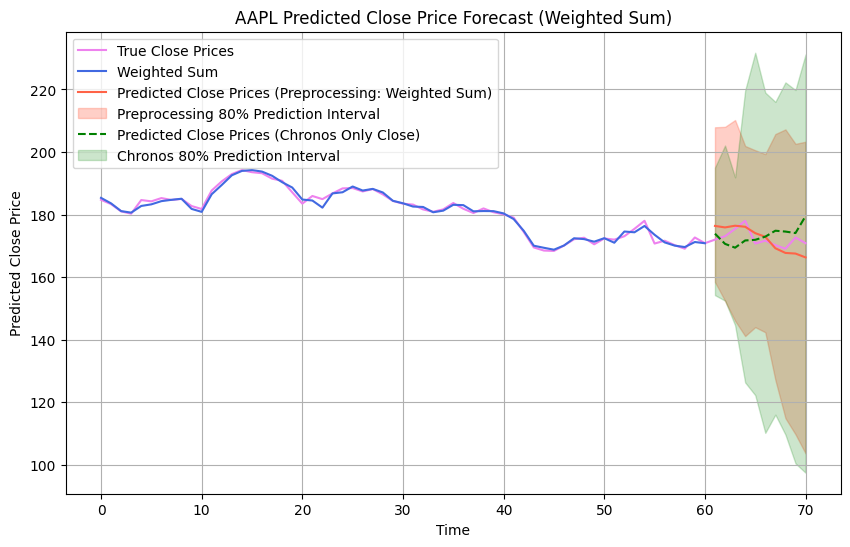

Arithmetic Mean
Variance: [ 5.5073643 13.079442  15.742865  18.996227  21.214993  23.32813
 28.434864  33.154198  44.107304  42.15708  ]


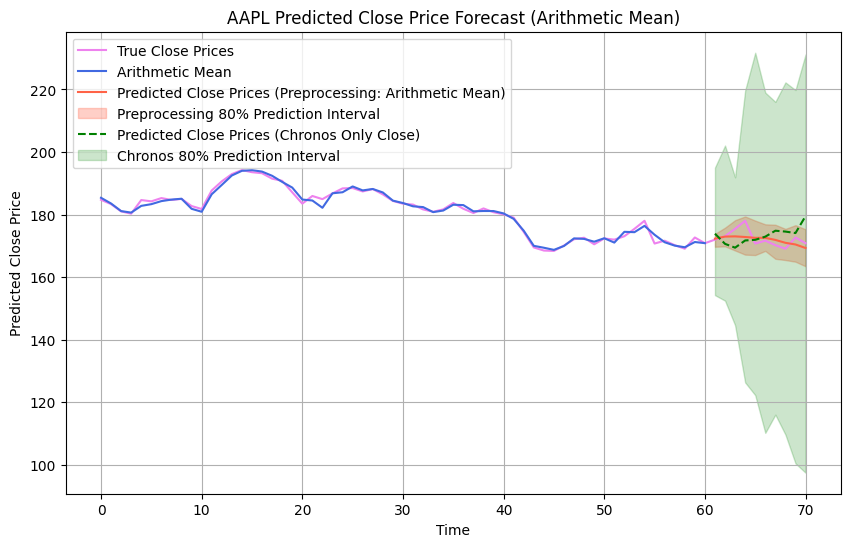

PCA
Variance: [ 2.0221512  5.7228127  7.7714005 12.00074   20.349255  19.631153
 19.719267  20.137802  28.107458  27.926828 ]


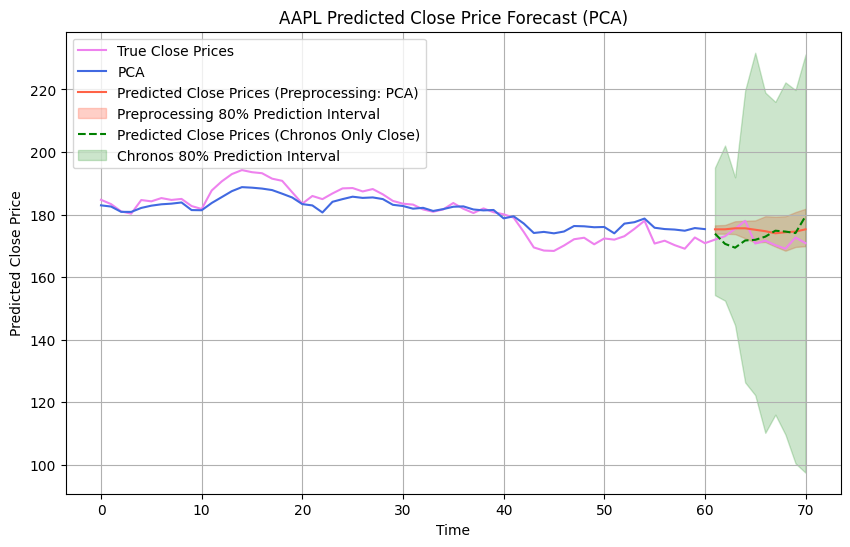

PERFORMANCE METRICS:
                          MSE      RMSE      MAPE      MASE
Chronos Only Close  21.673821  4.655515  1.728023  1.696319
Weighted Sum         9.414684  3.068336  2.335545  2.582169
Arithmetic Mean      5.064651  2.250478  1.234328  1.378566
PCA                 11.554544  3.399198  1.931387  3.284521
-------------------------------------------------
SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):
MSE     0.378240
RMSE    0.615012
MAPE    1.025683
MASE    1.337993
dtype: float64


In [37]:
reset_seed()  # For reproducibility

# Dictionary to store metrics
results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(close_values), prediction_length=prediction_length
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + prediction_length)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict # True values for comparison
results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'].values.reshape(-1))
all_close_values = np.concatenate([data['Close'].values, data_to_predict])

# Chronos prediction using preprocessing methods
methods = {
    "Weighted Sum": aapl_combined,
    "Arithmetic Mean": aapl_mean,
    "PCA": aapl_pca_series
}

for title, close_prices in methods.items():
    # Step 1: Chronos prediction
    forecast = pipeline.predict(
        context=torch.tensor(close_prices.values), prediction_length=prediction_length
    )

    forecast_index = range(len(close_prices), len(close_prices) + prediction_length)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)

    # Step 2: Compute metrics
    results[title] = compute_metrics(actual_values, mean_forecast, close_prices.values.reshape(-1))

    # Step 3: Visualization
    print(f"{title}")
    print(f'Variance: {variance_forecast}')

    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="True Close Prices")  # True Close Prices
    plt.plot(close_prices.values, color="royalblue", label=f"{title}")  # Close Prices using preprocessing methods

    # Predicted Close Prices using preprocessing methods
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {title})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast ({title})")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"Preprocessing_{title.replace(' ', '_')}.png")
    plt.show()


# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print("PERFORMANCE METRICS:")
print(results_df)

# Compute relative performance
relative_scores = agg_relative_score(results_df.iloc[1:], results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (Preprocessing vs Chronos Only Close):")
print(relative_scores)

## Pre-processing (from multivariate to univariate) using ML methods

Preprocessing to scale data:

In [38]:
reset_seed()  # For reproducibility

# Data preprocessing
scaler = StandardScaler()
X = data[['Open', 'High', 'Low', 'Volume']].values
y = data['Close'].values
X_scaled = scaler.fit_transform(X)

Define the ML methods:

In [39]:
# ML methods for regression
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=seed),
    "Support Vector Regression": SVR(kernel='rbf')
}

Chronos prediction using:
1. Only Close prices
2. Univariate data obtained from ML methods on multivariate data

Linear Regression Variance: [ 613.7114   811.55927 1137.5787  1030.8726  1080.661   1069.2866
 1301.3768  1600.109   1795.8936  2006.6565 ]


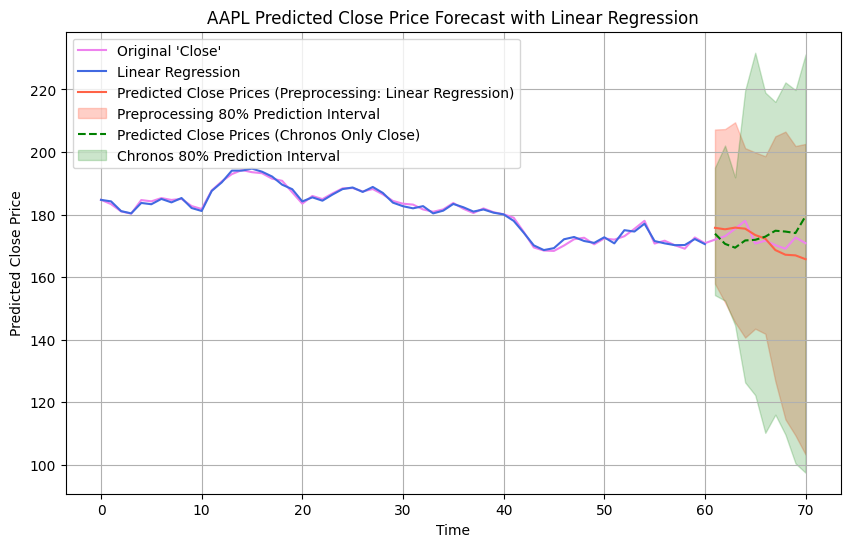

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random Forest Variance: [ 2.8672123  7.6591125 10.394195  13.494838  13.9661    10.266469
 14.142271  17.264933  29.680714  37.07997  ]


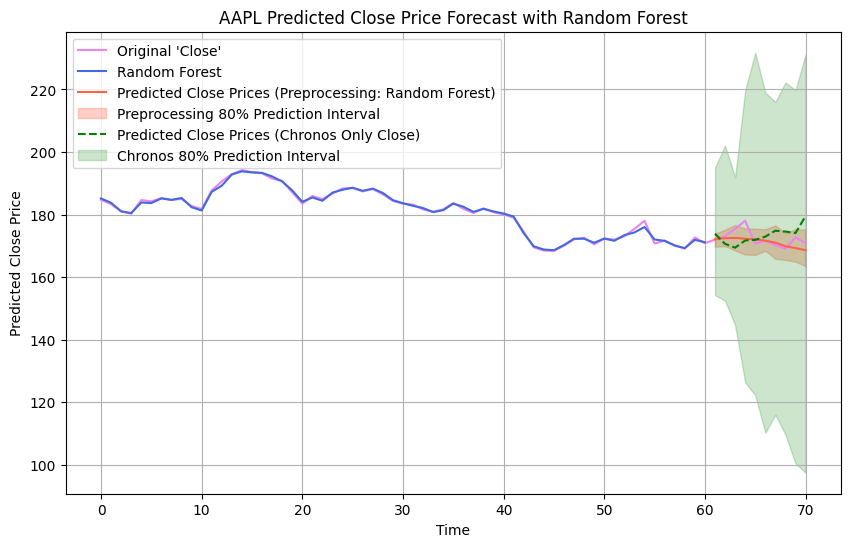

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector Regression Variance: [ 1.8097341  5.15617    8.436556  13.82168   16.111353  16.978765
 18.33495   22.70293   32.389984  44.256653 ]


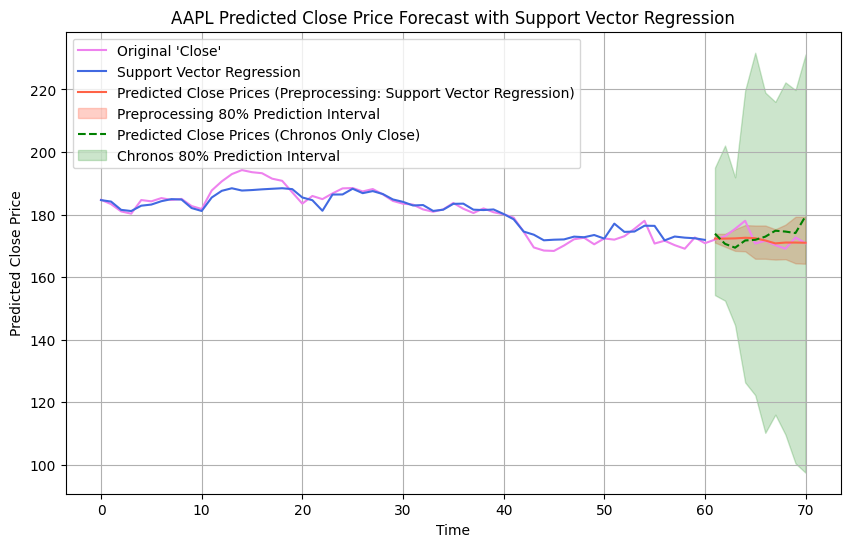

PERFORMANCE METRICS (ML Models):
                                 MSE      RMSE      MAPE      MASE
Chronos Only Close         21.673821  4.655515  1.728023  1.696319
Linear Regression           9.838859  3.136696  2.324761  2.264001
Random Forest               6.121669  2.474201  1.322556  1.469245
Support Vector Regression   4.927071  2.219701  1.127849  1.533061
-------------------------------------------------
SCALING PERFORMANCE (ML Models vs Chronos Only Close):
MSE     0.307751
RMSE    0.554753
MAPE    0.875921
MASE    1.014696
dtype: float64


In [40]:
reset_seed()  # For reproducibility

# Dictionary to store metrics for ML models
ml_results = {}

# Chronos prediction using only Close prices
forecast_close = pipeline.predict(
    context=torch.tensor(data['Close'].values), prediction_length=prediction_length
)

# Extract forecast statistics
forecast_index_close = range(len(data['Close']), len(data['Close']) + prediction_length)
low_close, median_close, high_close = np.quantile(forecast_close[0].numpy(), [0.1, 0.5, 0.9], axis=0)
mean_forecast_close = np.mean(forecast_close[0].numpy(), axis=0)

# Compute metrics for Chronos (Close-only)
actual_values = data_to_predict # True values for comparison
ml_results["Chronos Only Close"] = compute_metrics(actual_values, mean_forecast_close, data['Close'].values.reshape(-1))


for model_name, model in models.items():
    # Step 1: Fit the model
    model.fit(X_scaled, y)

    # Previsione dei valori di Close
    predicted_close = model.predict(X_scaled)

    # Step 2: Forecasting con Chronos
    forecast = pipeline.predict(
        context=torch.tensor(predicted_close), prediction_length=prediction_length
    )

    # Extract forecast statistics
    forecast_index = range(len(predicted_close), len(predicted_close) + prediction_length)
    low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)
    mean_forecast = np.mean(forecast[0].numpy(), axis=0)
    variance_forecast = np.var(forecast[0].numpy(), axis=0)
    all_close_values = np.concatenate([data['Close'].values, data_to_predict])

    # Store metrics in the results dictionary
    ml_results[model_name] = compute_metrics(actual_values, mean_forecast, predicted_close.reshape(-1))

    print(f"{model_name} Variance: {variance_forecast}")

    # Step 3: Visualization
    plt.figure(figsize=(10, 6))
    plt.plot(all_close_values, color="violet", label="Original 'Close'")  # Original Close Prices
    plt.plot(predicted_close, color="royalblue", label=f"{model_name}")  # Predicted Close

    # Predicted Close Prices using Chronos forecast
    plt.plot(forecast_index, mean_forecast, color="tomato", label=f"Predicted Close Prices (Preprocessing: {model_name})")
    plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="Preprocessing 80% Prediction Interval")

    # Add Chronos-only Close prediction
    plt.plot(forecast_index_close, mean_forecast_close, color="green", linestyle="dashed",
            label="Predicted Close Prices (Chronos Only Close)")
    plt.fill_between(forecast_index_close, low_close, high_close, color="green", alpha=0.2, label="Chronos 80% Prediction Interval")

    plt.title(f"{symbol} Predicted Close Price Forecast with {model_name}")
    plt.xlabel("Time")
    plt.ylabel("Predicted Close Price")
    plt.legend()
    plt.grid()
    plt.savefig(f"Preprocessing_{model_name.replace(' ', '_')}.png")
    plt.show()

# Convert results for ML models to DataFrame
ml_results_df = pd.DataFrame(ml_results).T
print("PERFORMANCE METRICS (ML Models):")
print(ml_results_df)

# Compute relative performance for ML models
relative_scores_ml = agg_relative_score(ml_results_df.iloc[1:], ml_results_df.iloc[0])  # Exclude Chronos Only Close as baseline
print("-------------------------------------------------")
print("SCALING PERFORMANCE (ML Models vs Chronos Only Close):")
print(relative_scores_ml)
